In [ ]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm

from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from joblib import Parallel, delayed
import os

model = 'ViT_Cap_VW'

port = pd.read_csv(r'Factor_port\\' + model + '.csv', index_col=0)
port.index = pd.to_datetime(port.index)

start_date = pd.to_datetime('2001-01-01')
end_date = pd.to_datetime('2024-12-31')

port = port[(port.index >= start_date) & (port.index <= end_date)]

ff3 = pd.read_csv(r'data\processed_kelly\ff3.csv', index_col=0)
ff3.index = pd.to_datetime(ff3.index)
ff3 = ff3[start_date:end_date]

ff5 = pd.read_csv(r'data\processed_kelly\ff5.csv', index_col=0)
ff5.index = pd.to_datetime(ff5.index)
ff5 = ff5[start_date:end_date]

q5 = pd.read_csv(r'data\processed_kelly\q5.csv')
q5.set_index('date', inplace=True)
q5.index = pd.to_datetime(q5.index)
q5 = q5[start_date:end_date]
q5.index.name = None

test_portfolios = pd.read_csv(r'data\processed_kelly\test_portfolios.csv')
test_portfolios.set_index('date', inplace=True)
test_portfolios.index = pd.to_datetime(test_portfolios.index)
test_portfolios = test_portfolios[start_date:end_date]
test_portfolios = test_portfolios
test_portfolios.index.name = None

mom = pd.read_csv(r'data\processed_kelly\ff_mom.csv', index_col=0)
mom.index = pd.to_datetime(mom.index)
mom = mom[start_date:end_date]

kelly_factors = pd.read_csv(r'data\processed_kelly\kelly_factor.csv')
kelly_factors.set_index('date', inplace=True)
kelly_factors.index = pd.to_datetime(kelly_factors.index)
kelly_factors = kelly_factors[start_date:end_date]
kelly_factors.index.name = None

ff3.index = port.index
ff5.index = port.index
q5.index = port.index
test_portfolios.index = port.index
mom.index = port.index
kelly_factors.index = port.index
rf = ff3['RF']

factor_zoo = pd.concat([np.round(kelly_factors*100,4) ,ff5[['Mkt-RF','SMB','HML','RMW','CMA']],q5[['R_ME','R_IA','R_ROE']],np.round(port[[model.split('_')[0]]] * 100 ,4)],axis=1)

h_t = factor_zoo.iloc[:,:-1].copy()
h_t = np.array(h_t)
g_t = np.array(factor_zoo.iloc[:,-1:])

beta_k_df = pd.read_csv(r'data//beta_k.csv', index_col=0)
mean_betas = (beta_k_df**2).mean(axis=0)
penalty = (mean_betas/mean_betas.mean())

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman' # Times New Roman

In [2]:
lambda1_1se = []

for path in glob(r'legacy_result\Fisrt_Lasso\*'):
    temp = pd.read_csv(path)
    mean_errors = temp.mean(axis=0)
    se = temp.std(axis=0) / np.sqrt(temp.shape[0])
    min_mse = mean_errors.iloc[mean_errors.argmin()]
    best_idx = mean_errors[mean_errors == min_mse].index[0]
    candidate = mean_errors[mean_errors <= (min_mse + se[best_idx])].idxmax()
    lambda1_1se.append(int(candidate))

In [3]:
lambda1_1se = []

for path in glob(r'legacy_result\Fisrt_Lasso\*'):
    temp = pd.read_csv(path)
    mean_errors = temp.mean(axis=0)
    se = temp.std(axis=0) / np.sqrt(temp.shape[0])
    min_mse = mean_errors.iloc[mean_errors.argmin()]
    best_idx = mean_errors[mean_errors == min_mse].index[0]
    candidate = mean_errors[mean_errors <= (min_mse + se[best_idx])].idxmax()
    lambda1_1se.append(int(candidate))

In [4]:
lambda2_1se = []

for path in glob(r'result\ViT_Cap_VW\*'):
    temp = pd.read_csv(path)
    mean_errors = temp.mean(axis=0)
    se = temp.std(axis=0) / np.sqrt(temp.shape[0])
    min_mse = mean_errors.iloc[mean_errors.argmin()]
    best_idx = mean_errors[mean_errors == min_mse].index[0]
    candidate = mean_errors[mean_errors <= (min_mse + se[best_idx])].idxmax()
    lambda2_1se.append(int(candidate))

In [5]:
# lasso 1 with -3.18 alpha

# first_lasso_cov
first_lasso_cov_lst = []
for idx in range(test_portfolios.shape[1]):
    y_i = test_portfolios.iloc[:, idx]
    not_nan_idx = ~np.isnan(y_i)
    y_i = y_i[not_nan_idx]
    x = h_t[not_nan_idx]
    first_lasso_cov_lst.append(np.cov(y_i, x.T, ddof=1)[0, 1:])

first_lasso_cov = np.array(first_lasso_cov_lst)
mean_ri = np.mean(test_portfolios, axis=0).values.reshape(-1, 1)

# second lasso_cov
second_lasso_cov_lst = []
for idx in range(test_portfolios.shape[1]):
    y_i = test_portfolios.iloc[:, idx]
    not_nan_idx = ~np.isnan(y_i)
    y_i = y_i[not_nan_idx]
    x = g_t[not_nan_idx]
    second_lasso_cov_lst.append(np.cov(y_i,x.T,ddof=1)[0,1:])

second_lasso_cov = np.array(second_lasso_cov_lst)

In [6]:
lasso1_mse_lst = []
lasso2_mse_lst = []

NumLambda = 100

lambdas1 = np.exp(np.linspace(0, -35, NumLambda))
lambdas2 = np.exp(np.linspace(0, -35, NumLambda))

In [7]:
lambda1_cnt = pd.DataFrame(lambda1_1se).value_counts()

In [8]:
result1 = []
for idx in tqdm(range(len(lambda1_cnt))):
    lambda_idx = lambda1_cnt.index[idx][0]
    cnt = lambda1_cnt.iloc[idx]
    lasso1 = Lasso(alpha=lambdas1[lambda_idx], fit_intercept=True, max_iter=10000,tol=1e-5)
    lasso1.fit(first_lasso_cov * penalty.values, mean_ri)
    lasso1.coef_
    for iter in range(cnt):
        result1.append(list((pd.DataFrame(lasso1.coef_)/(pd.DataFrame(lasso1.coef_)))[0].fillna(0).astype(int)))

100%|██████████| 29/29 [00:24<00:00,  1.21it/s]


In [9]:
lambda2_cnt = pd.DataFrame(lambda2_1se).value_counts()

result2 = []
for idx in tqdm(range(len(lambda2_cnt))):
    lambda_idx = lambda2_cnt.index[idx][0]
    cnt = lambda2_cnt.iloc[idx]
    lasso2 = Lasso(alpha=lambdas1[lambda_idx], fit_intercept=True, max_iter=10000,tol=1e-5)
    lasso2.fit(first_lasso_cov * penalty.values, second_lasso_cov)  
    lasso2.coef_

    for iter in range(cnt):
        result2.append(list((pd.DataFrame(lasso2.coef_)/(pd.DataFrame(lasso2.coef_)))[0].fillna(0).astype(int)))

100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


In [10]:
plt.rcParams["font.family"] = "Times New Roman"

In [36]:
rslt_df1 = pd.DataFrame(result1)
rslt_df1.columns = factor_zoo.columns[:-1]
print('First Lasso')
rslt_df1.sum(axis=0).sort_values().T.tail(19)[::-1]

First Lasso


zero_trades_126d        161
eqnetis_at              161
prc                     161
ni_inc8q                160
tangibility             157
mispricing_perf         151
rd_me                   151
Mkt-RF                  143
RMW                     137
taccruals_ni            126
ni_ar1                  122
sale_bev                122
resff3_12_1             122
earnings_variability    122
seas_6_10na             111
oaccruals_at            111
niq_be                  109
qmj                     107
qmj_safety               96
dtype: int64

In [114]:
rslt_df2 = pd.DataFrame(result2)
rslt_df2.columns = factor_zoo.columns[:-1]
print('Second Lasso ViT')
rslt_df2.sum(axis=0).sort_values()[::-1].to_csv('second_lasso_vit_selectionrate.csv')

Second Lasso ViT


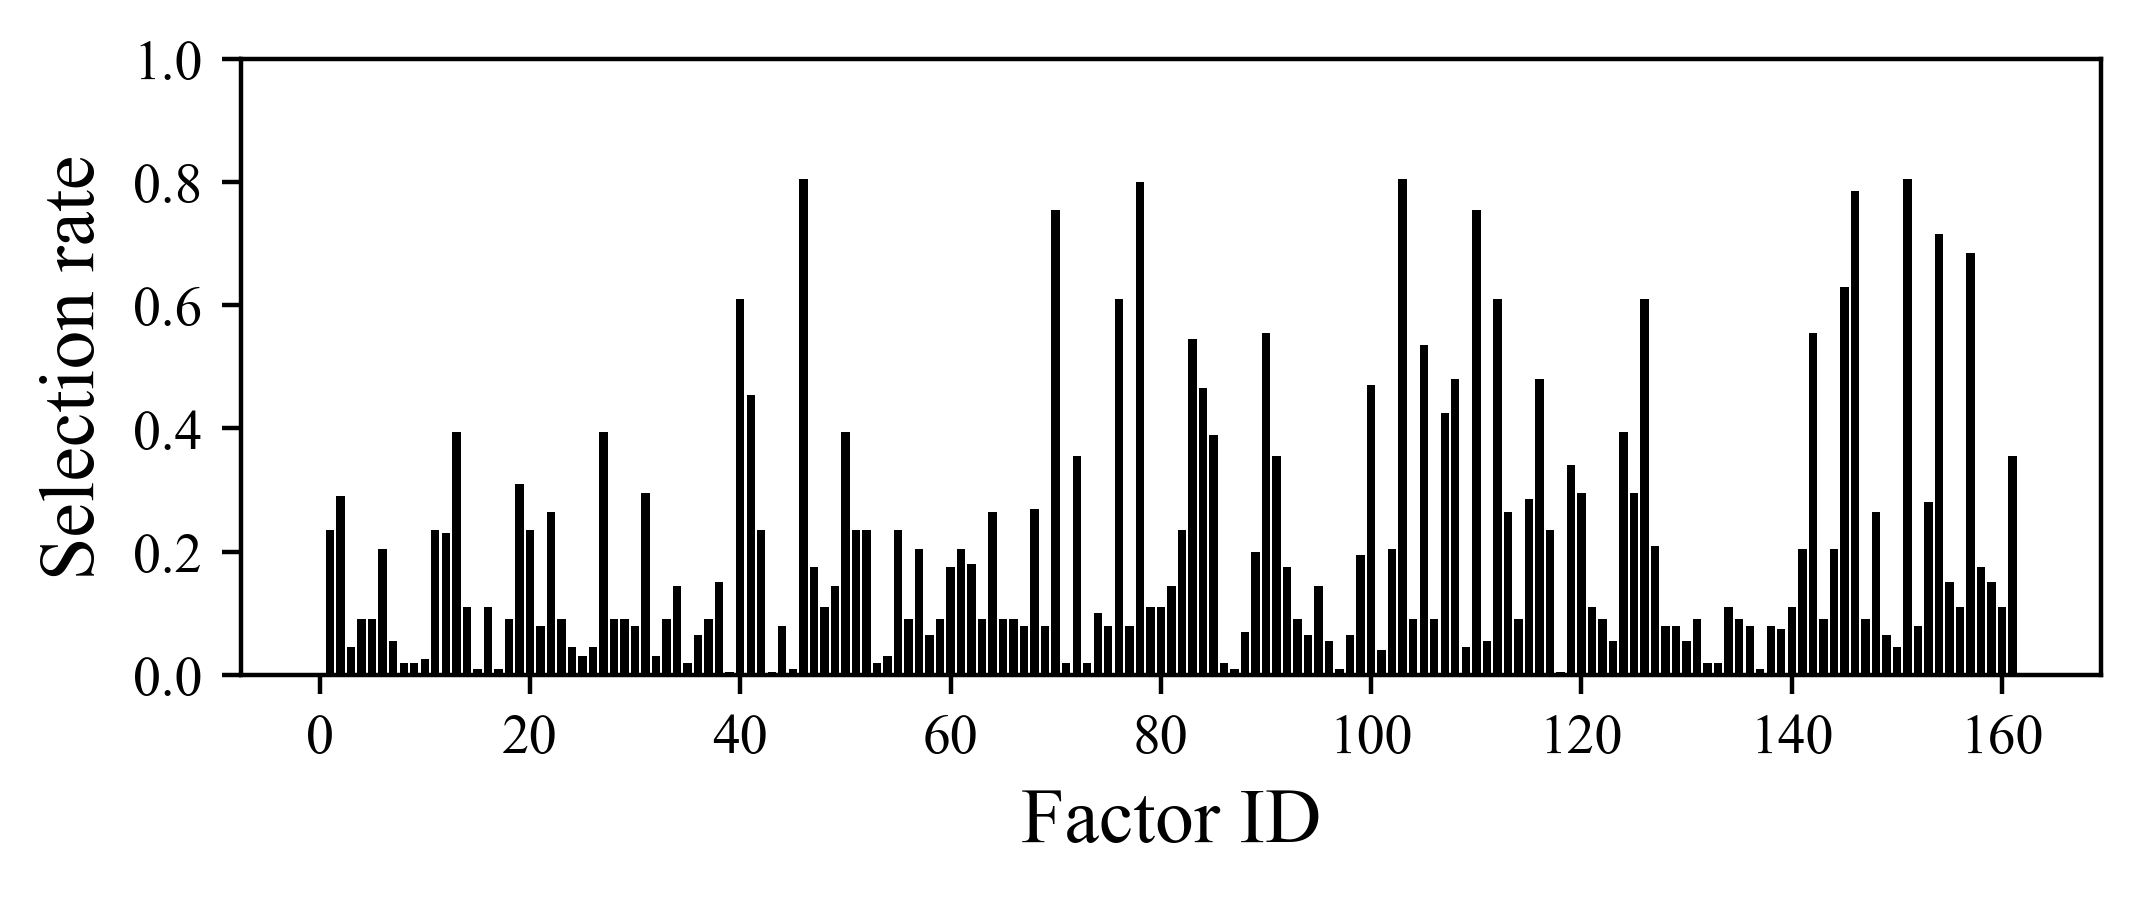

In [28]:
plt.figure(figsize=(6,2),dpi=400)
plt.bar((pd.DataFrame(result1).sum(axis=0)/200).index+1,(pd.DataFrame(result1).sum(axis=0)/200),color='black')
plt.ylim(0,1.0)
plt.ylabel("Selection rate",fontsize=14)
plt.xlabel("Factor ID",fontsize=14)
plt.savefig('fig_firstlasso_selection_ratio.png', dpi=400, bbox_inches='tight')

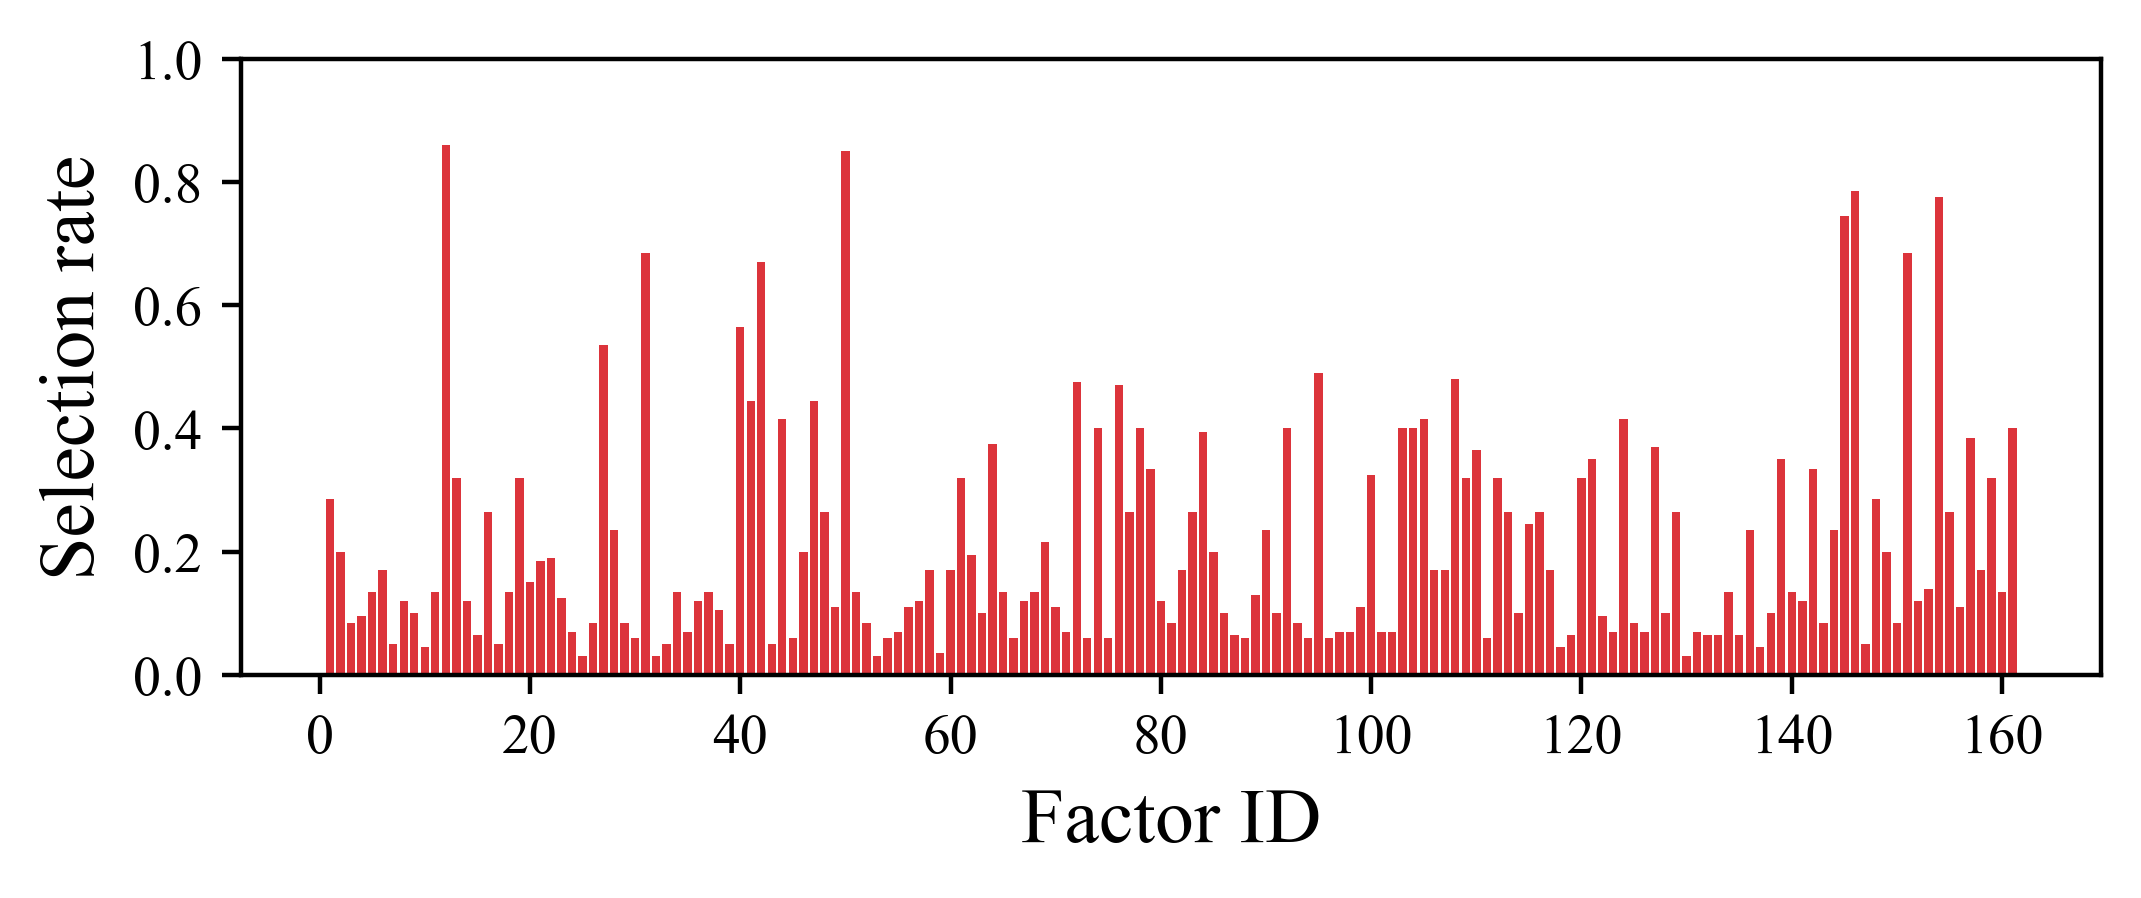

In [30]:
plt.figure(figsize=(6,2),dpi=400)
plt.bar((pd.DataFrame(result2).sum(axis=0)/200).index+1,(pd.DataFrame(result2).sum(axis=0)/200),color='#DC343B')
plt.ylim(0,1.0)
plt.ylabel("Selection rate",fontsize=14)
plt.xlabel("Factor ID",fontsize=14)
plt.savefig('fig_secondlasso_vit_selection_ratio.png', dpi=400, bbox_inches='tight')

In [31]:
factor_zoo.columns[:-1]

Index(['age', 'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me',
       'at_turnover', 'be_gr1a', 'be_me',
       ...
       'zero_trades_21d', 'zero_trades_252d', 'Mkt-RF', 'SMB', 'HML', 'RMW',
       'CMA', 'R_ME', 'R_IA', 'R_ROE'],
      dtype='object', length=161)

In [15]:
heatmap_df = pd.DataFrame([lambda1_1se,lambda2_1se]).T
heatmap_df.columns = ['first','second']

In [16]:
lasso1_coef_dict = {}

for idx in tqdm(list(set(heatmap_df['first']))):
    lasso1 = Lasso(alpha=lambdas1[idx], fit_intercept=True, max_iter=10000,tol=1e-5)
    lasso1.fit(first_lasso_cov * penalty.values, mean_ri)
    lasso1_coef_dict[idx] = list((pd.DataFrame(lasso1.coef_)/(pd.DataFrame(lasso1.coef_)))[0].fillna(0).astype(int))

100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


In [17]:
lasso2_coef_dict = {}

for idx in tqdm(list(set(heatmap_df['second']))):
    lasso2 = Lasso(alpha=lambdas1[idx], fit_intercept=True, max_iter=10000,tol=1e-5)
    lasso2.fit(first_lasso_cov * penalty.values, second_lasso_cov)  
    lasso2_coef_dict[idx] = list((pd.DataFrame(lasso2.coef_)/(pd.DataFrame(lasso2.coef_)))[0].fillna(0).astype(int))

100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


In [18]:
var_count = []
for i in range(200):
    f,s = heatmap_df.iloc[i]
    control_cnt = np.array(lasso1_coef_dict[f]) + np.array(lasso2_coef_dict[s])
    var_count.append((control_cnt!=0).sum())
heatmap_df['count'] = var_count

In [19]:
np.exp(-2.828)

np.float64(0.05913099748121725)

In [20]:
np.log(lambdas1[8])

np.float64(-2.8282828282828283)

In [21]:
heatmap_df['first'] = heatmap_df['first'].apply(lambda x : np.log(lambdas1[x]))
heatmap_df['second'] = heatmap_df['second'].apply(lambda x : np.log(lambdas2[x]))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

df = heatmap_df.drop_duplicates()  

x = df['first'].to_numpy()
y = df['second'].to_numpy()
z = df['count'].to_numpy()

xi = np.linspace(x.min(), x.max(), 400)
yi = np.linspace(y.min(), y.max(), 400)
XI, YI = np.meshgrid(xi, yi)

ZI = griddata((x, y), z, (XI, YI), method='cubic')

ZI_nearest = griddata((x, y), z, (XI, YI), method='nearest')
ZI[np.isnan(ZI)] = ZI_nearest[np.isnan(ZI)]


fig, ax = plt.subplots(figsize=(6, 5),dpi=400)
im = ax.imshow(
    ZI, origin='lower',
    extent=[xi.min(), xi.max(), yi.min(), yi.max()],
    aspect='auto', vmin=0, vmax=161  
)
plt.colorbar(im, ax=ax)


ax.scatter(x, y, s=8, c='k')

ax.scatter(np.log(lambdas1[8]),np.log(lambdas2[8]), marker='x', s=70, c='r')
ax.set_xlim(-12,-2)
ax.set_ylim(-12,-2)
ax.set_xlabel('First LASSO log(λ)', fontsize=14)
ax.set_ylabel('Second LASSO log(λ)', fontsize=14)
plt.tight_layout()
plt.savefig('fig_vit_frequency_heatmap.png', dpi=400, bbox_inches='tight')
plt.close()
